# MyTrain

## DataSetInitialization

In [1]:
import sys
import logging
from logging import getLogger
from recbole.utils import init_logger, init_seed
from mamba4poi import Mamba4POI
from recbole.config import Config
from utils import *
from recbole.data.transform import construct_transform
from recbole.utils import (
    init_logger,
    get_model,
    get_trainer,
    init_seed,
    set_color,
    get_flops,
    get_environment,
)
import torch
from myutils import * 

config = Config(model=Mamba4POI, config_file_list=['config.yaml'])
dataset = create_dataset(config)

In [2]:
import gc
for obj in gc.get_objects():
    if torch.is_tensor(obj) and obj.is_cuda:
        print(type(obj), obj.size())


d:\CODEING\Anaconda\envs\Pytorch\lib\site-packages\torch\__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


# HyperGraphModel

#### notes:
We use a **HyperGraph Neural Network** to model the complex interactions among users, categories, and POIs, calculating the weight of hyperedges to reflect users' **interests in both categories and POIs**.<br>
Unlike our sequential prediction model, which predict user interest in the dynamic time sequence, the HGNN addresses the issue of dissimilar interests in the same POI caused by users' varied **breadth of interests** despite having equal interaction levels,by modeling static user profiles.The **distinction** between the two modules is determined by their approach to **utilizing interactions**: ***dynamically or statically***<br>
#### Nodes defination:
We detatch category from POI features to modeling its latent<br> relation between both POI and user<br><br>
**User**:       10dims for 3 features<br>
*num_poi_interaction*:int,*num_category_interaction*:int<br>
***active_area:tensor***(4,2) <--training target<br><br>
**Category**:   1dim for 1 feature<br>
*num_poi*:int,sigma:float(2,),center:float(2,)<br>
***using poi geographic distribution feature to reflect the feature of category***<br>
<br><br>
**POI**:        2dims for 1feature<br>
*location*:tensor(2,)<br>

             

#### Weight updating policy:
Our Hyperedge connected with three varied type nodes,whose weight can't be fully normalized as scalar,are designed with vector weight.Using attention mechanism to reflect the diffrent impact from nodes.



In [3]:
from HGNN import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
POI_interaction_matrix,category_interaction_matrix,category_ids_counts=counting4all(dataset,device)
itemX = torch.tensor(dataset.item_feat["x"], dtype=torch.float32)
itemY = torch.tensor(dataset.item_feat["y"], dtype=torch.float32)



In [11]:
def active_center_point(interaction_matrix,itemX,itemY,device):
    torch.cuda.empty_cache()
    weight=interaction_matrix.to(device)/interaction_matrix.to(device).sum(dim=0,keepdim=True)
    itemX=itemX.to(device)
    itemY=itemY.to(device)
    center_x,center_y=weight@itemX,weight@itemY

    X=((interaction_matrix!=0).float().to(device)*itemX).cpu()
    Y=((interaction_matrix!=0).float().to(device)*itemY).cpu()
   
    Xmin,_=X[X>0].min(dim=1)
    Ymin,_=Y[Y>0].min(dim=1)
    Xmax,_=X.max(dim=1)
    Ymax,_=Y.max(dim=1)
   

    maxDx,_=(torch.abs(center_x-torch.stack((Xmax,Xmin),dim=0).to(device))).max(0)
    maxDy,_=(torch.abs(center_y-torch.stack((Ymax,Ymin),dim=0).to(device))).max(0)
    print(torch.stack((Xmax,Xmin),dim=0))
    radius=maxDx+maxDy
    
    return center_x,center_y,radius

center_X,center_Y,radius=active_center_point(POI_interaction_matrix,itemX,itemY,device)


sim=category_interest_similarity(category_interaction_matrix,device)
print(center_X[100],center_Y[100],radius[100])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

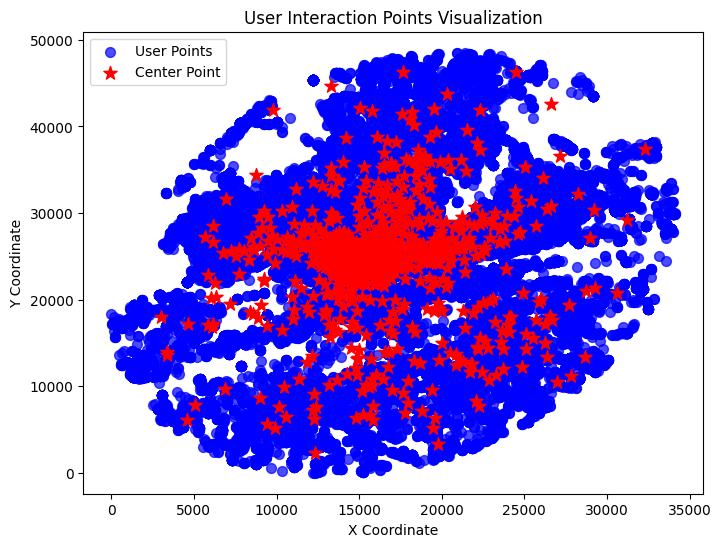

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 数据加载
items = dataset.inter_feat["venue_id"]
users = dataset.inter_feat["user_id"]

itemX, itemY = dataset.item_feat["x"], dataset.item_feat["y"]
usercenter_X = center_X[100].cpu()
usercenter_Y = center_Y[100].cpu()
userx = itemX[items]
usery = itemY[items]
userradius = radius[100].cpu()

# 创建图形
plt.figure(figsize=(8, 6))

# 绘制用户交互点
plt.scatter(userx, usery, c='blue', s=50, label='User Points', alpha=0.7)

# 绘制中心点
plt.scatter(usercenter_X, usercenter_Y, c='red', s=100, marker='*', label='Center Point')

# 绘制正方形
half_side = userradius / 2
square = Rectangle(
    (usercenter_X - half_side, usercenter_Y - half_side),  # 左下角坐标
    width=userradius / 2,                                 # 宽度
    height=userradius / 2,                                # 高度
    edgecolor='green',
    facecolor='none',  # 透明填充
    linewidth=2,
    label="Bounding Square"
)
plt.gca().add_patch(square)

# 设置标题和轴标签
plt.title("User Interaction Points Visualization with Bounding Square")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# 添加图例
plt.legend()

# 显示图形
plt.show()


### Venue Category Analysis

# 负采样优化
空间融合基本方法：基于流行度采样之上，候选负样本缩小到用户活动范围内，目的是排除活动范围外流行的伪负样本
活动范围：用户交互过的地点位置取最大外切矩形
分层采样：依据交互次数排行 找到频繁访问区域作为生活区 最少访问区域作为危险区 其余部分作为探索区
假设1：用户熟知生活区所有地点，因此没有访问的地点作为负样本
假设2：危险区可能是用户真的不感兴趣的区域 也有可能是不方便涉足的区域，可以根据危险区和生活区的距离进行从分段处理控制采样比例 危险区采样比例根据其与生活区距离
探索区域：融合类目分布进行采样


物品的特征可以这样观察 冷门-流行 丰富-稀有 再加上用户访问次数特征 构建出一个三维空间
丰富稀有可以转化成 日常化程度 
#### 假设1：相比更日常的地点人们对稀有的地点更感兴趣
#### 假设2：用户更多访问的地方可能不是因为感兴趣而是因为日常生活需要
#### 假设3：用户的频繁访问点是集中的，用户频繁访问区内的地点用户都熟知，未访问的地点大概率是不感兴趣
#### 假设4：用户频繁访问区外的用户的偶尔访问点是集中的，用户偶尔访问区根据与频繁访问区的距离可以感知用户是对这块区域没兴趣还是不方便探索，这个距离是根据整体区域大小裁定的
#### 假设5：除了偶尔访问区和频繁访问区，剩下的探索区是很未知的，
#### 假设6：根据频繁访问区每个类目 用户访问占区域内总数比例 粗略推断用户对类目的兴趣 把这个权重作用在探索区
#### 策略1：根据全体交互item划分出总区域
#### 策略2：根据分位数划分出频繁访问item，在划分出频繁访问去地理包络，记录包络中心点位置，包络中未访问的项目直接划分成候选负样本
#### 策略3：在频繁访问区地理包络外根据分位数划分出偶尔访问item，得到偶尔访问区地理包络，以中心位置到频繁访问区中心位置距离和总区域斜边两者倒数比来度量相近程度作为偶尔访问区采样权重



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

POI_interaction_matrix,category_interaction_matrix,category_ids_counts=counting4all(dataset,device)

reciprocalrarity=reciprocal_rarity(category_ids_counts)
exprarity=exp_rarity(category_ids_counts,device)

#### 现象1：活跃用户和非活跃用户的交互分布特征相似 大多数访问的地点去的次数很少 只有少数地点去了很多次 这些地点反映用户兴趣

In [ ]:
import torch
import plotly.express as px
import numpy as np

# 假设 interaction_matrix 是给定的张量
# Step 1: Identify the most active user (column with max interactions excluding the first row and column)
active_user_idx = category_interaction_matrix[1:, 1:].sum(1).argmax()
active_user = category_interaction_matrix[active_user_idx+1,:].cpu().numpy()

# Step 2: Identify the least active user (column with min interactions excluding the first row and column)
inactive_user_idx = category_interaction_matrix[1:, 1:].sum(1).argmin()
inactive_user = category_interaction_matrix[inactive_user_idx+1,:].cpu().numpy()

# 计算均值
mean_interaction = category_interaction_matrix[1:,1:].mean(dtype=torch.float32)
ordinary_user_idx = (abs(category_interaction_matrix[1:,1:] - mean_interaction)).argmin()
ordinary_user=category_interaction_matrix[ordinary_user_idx+1,:].cpu().numpy()

# Step 3: Filter out zeros
active_user = active_user[active_user > 0]
inactive_user = inactive_user[inactive_user > 0]
ordinary_user=ordinary_user[ordinary_user>0]

# Step 4: Create DataFrames for Plotly
active_df = pd.DataFrame({"Interactions": active_user, "User Type": "Active User"})
inactive_df = pd.DataFrame({"Interactions": inactive_user, "User Type": "Inactive User"})
ordinary_df= pd.DataFrame({"Interactions": ordinary_user, "User Type": "Ordinary User"})

# Combine both for easier plotting
combined_df = pd.concat([active_df, inactive_df,ordinary_df])
print(active_user.sum(),inactive_user.sum(),ordinary_user.sum())
# Step 5: Plot histograms using Plotly

fig = px.histogram(
    combined_df,
    x="Interactions",
    color="User Type",
    title=(
      "How can users' interests be effectively measured,<br>"
      "while balancing the trade-off between interest breadth and depth,<br>"
      "as illustrated by interaction quantities of <br>"
      "User-Category and Category-POI (user-wise) or User-POI?"),
    labels={"Interactions": "Number of Interactions", "User Type": "User Type"},
    nbins=100,  # Adjust the number of bins as needed
)

# Customize the title position and style
fig.update_layout(
    title={
        "y": 0.7,  # Adjust vertical position (1.0 is top, 0.0 is bottom)
        "x": 0.5,   # Adjust horizontal position (0.5 is centered)
        "xanchor": "center",  # Anchor to center
        "yanchor": "top",     # Anchor to top
        "font": {"size": 16},  # Adjust font size
    }
)


fig.show()


2697 100 109


问题：如何区分大量的少交互地点进行兴趣度量 实际上访问次数极多的地点不具有参考价值 它们可能是日常所需，不能很好地反映兴趣
方案：把地点访问次数转化成类目访问次数 
首先把userid-itemid交互序列转化成userid-categoryid交互序列进行归并 这样地分布更加平滑，访问总次数是一样的，只不过把大量只访问一次的地点归并成访问多次的类目。 
这样我们就可以区分访问次数极少的地点 

基于类目的兴趣度量：
假设：偶尔访问类目和频繁访问类目不能反映兴趣
定义用户兴趣类目：排除极端访问次数类目后的类目

问题：用户对访问次数相同的类目兴趣度一致吗？应该怎么区分？
方案：基于类目稀有度的加权，同样的访问次数，用户很可能对更稀有的类目感兴趣，引入类目稀有度矩阵

后续模型修改：
引入兴趣广度概念：不同用户以同样次数访问同个地点，反映的兴趣度是不同的，应该依赖用户访问总类目数量进行加权度量，得到更合理的用户-地点相似度

问题：如何把类目数量权重映射到稀有度上？
直接映射：倒数加权，这样的得到的稀有度是突变的 我希望稀有度

In [ ]:
import plotly.graph_objects as go
import torch


reciprocal_rarity=reciprocalrarity.cpu()
exp_rarity=exprarity.cpu()

# 创建图表对象
fig = go.Figure()

# Reciprocal Rarity Histogram
fig.add_trace(go.Histogram(
    x=reciprocal_rarity[1:],
    nbinsx=1000,
    name="Reciprocal Rarity",
    marker_color="skyblue",
    histnorm='probability',
    opacity=0.7,
    showlegend=True  # 不显示图例
))

# Log Rarity Histogram
fig.add_trace(go.Histogram(
    x=exp_rarity[1:],
    nbinsx=500,
    name="Exp Rarity",
    marker_color="lightgreen",
    opacity=0.7,
    histnorm='probability',
    showlegend=True  # 不显示图例
))

# 计算方差和峰度
reciprocal_var = torch.var(reciprocal_rarity[1:])
reciprocal_kurt = kurtosis(reciprocal_rarity[1:])
exp_var = torch.var(exp_rarity[1:])
exp_kurt = kurtosis(exp_rarity[1:])


# 添加外部文本框显示方差和峰度
fig.add_annotation(
    x=0.5,  # x轴位置，控制文本框水平位置
    y=1.15,  # y轴位置，调整文本框在图表的外部
    text=f"Reciprocal Rarity\nVar: {reciprocal_var:.4e}, Kurtosis: {reciprocal_kurt:.4e}",
    showarrow=False,
    font=dict(size=12, color="black"),
    align="center",
    bgcolor="white",
    opacity=0.8,
    xref="paper",  # 使用 'paper' 坐标系，让文本框不受图表范围限制
    yref="paper"   # 使用 'paper' 坐标系，使文本框在图表外
)

fig.add_annotation(
    x=0.5,  # x轴位置，控制文本框水平位置
    y=1.05,  # y轴位置，调整文本框在图表的外部
    text=f"Exp Rarity\nVar: {exp_var:.4e}, Kurtosis: {exp_kurt:.4e}",
    showarrow=False,
    font=dict(size=12, color="black"),
    align="center",
    bgcolor="white",
    opacity=0.8,
    xref="paper",  # 使用 'paper' 坐标系，放置在图表外
    yref="paper"   # 使用 'paper' 坐标系，放置在图表外
)

# 更新布局
fig.update_layout(
    title="Histograms of Reciprocal and Log Rarity",
    xaxis_title="Value",
    yaxis_title="Frequency",
    title_font_size=20,
    barmode="overlay",  # 使用 "overlay" 叠加直方图，"group" 可并排显示
    showlegend=True    # 隐藏图例
)

# 显示图表
fig.show()#5.96

In [ ]:
import torch
import numpy as np
import pandas as pd


# 2. 将数据转为 PyTorch Tensor 并移动到 GPU 上
venue_id = torch.tensor(venue_id, dtype=torch.long).cuda()  
venue_category = torch.tensor(venue_category, dtype=torch.long).cuda()
x = torch.tensor(x, dtype=torch.float32).cuda()  
y = torch.tensor(y, dtype=torch.float32).cuda()

# 3. 设置网格的尺寸（例如：每个网格大小为500x500）
grid_width = 500  # 网格宽度
grid_height = 500  # 网格高度

# 4. 计算网格的数量（基于坐标的最大最小值）
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# 计算网格行列数
num_x_grids = int((x_max - x_min) // grid_width) + 1
num_y_grids = int((y_max - y_min) // grid_height) + 1


# 5. 分批次处理
batch_size = 10000  # 每批处理的样本数量
num_batches = len(venue_id) // batch_size + 1  # 批次数量

# 创建稠密张量来暂存更新，最后将其转换为稀疏张量
venue_density_matrix = torch.zeros((num_y_grids, num_x_grids), dtype=torch.int32).cuda()
category_density_matrix = torch.zeros((num_y_grids, num_x_grids, len(torch.unique(venue_category))), dtype=torch.int32).cuda()

for batch_idx in range(num_batches):
    # 计算每个批次的索引范围
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(venue_id))
    
    # 获取当前批次数据
    batch_venue_id = venue_id[start_idx:end_idx]
    batch_venue_category = venue_category[start_idx:end_idx]
    batch_x = x[start_idx:end_idx]
    batch_y = y[start_idx:end_idx]

    # 计算每个数据点所属的网格
    grid_x = ((batch_x - x_min) / grid_width).floor().long()  # 计算 x 对应的网格位置
    grid_y = ((batch_y - y_min) / grid_height).floor().long()  # 计算 y 对应的网格位置

    # 确保网格索引不超出边界
    grid_x = torch.clamp(grid_x, 0, num_x_grids - 1)
    grid_y = torch.clamp(grid_y, 0, num_y_grids - 1)

    # 使用 scatter_add_ 更新稠密张量的计数
    venue_density_matrix.index_put_((grid_y, grid_x), torch.ones(len(grid_y), dtype=torch.int32).cuda(), accumulate=True)
    
    # 更新类别密度矩阵
    for i in range(len(batch_venue_category)):
        category_density_matrix[grid_y[i], grid_x[i], batch_venue_category[i]] += 1

# 7. 将稠密张量转换为稀疏张量
venue_density_matrix_sparse = venue_density_matrix.to_sparse()
category_density_matrix_sparse = category_density_matrix.to_sparse()

# 8. 打印结果
print("Venue Density Matrix Sparse:")
print(venue_density_matrix_sparse)
print("Category Density Matrix Sparse:")
print(category_density_matrix_sparse)


NameError: name 'venue_id' is not defined

In [ ]:
import plotly.graph_objects as go
import plotly.colors as pc
import torch

# 假设 venue_density_matrix_sparse 是一个 PyTorch tensor
# 你可以根据你实际的场景替换这个变量
venue_density_matrix_sparse = torch.rand(num_y_grids, num_x_grids)  # 模拟密度矩阵

# 将 x_min 和 y_min 移回 CPU
xmin = x_min.cpu().item()
ymin = y_min.cpu().item()

# 创建空的图形对象
fig = go.Figure()

# 定义颜色范围，这里选择一个颜色调色板，如蓝色渐变
color_scale = 'Blues'  # 可以选择其他颜色范围，如 'Viridis', 'Cividis', 'Inferno'

# 使用 PyTorch 的 max 和 min 函数
max_density = torch.max(venue_density_matrix_sparse).item()  # 获取最大密度
min_density = torch.min(venue_density_matrix_sparse).item()  # 获取最小密度
normalized_density = (venue_density_matrix_sparse - min_density) / (max_density - min_density)  # 归一化

# 添加网格图层：根据密度值使用颜色
for i in range(num_y_grids):
    for j in range(num_x_grids):
        # 计算网格的边界
        grid_x_min = xmin + j * grid_width
        grid_x_max = grid_x_min + grid_width
        grid_y_min = ymin + i * grid_height
        grid_y_max = grid_y_min + grid_height
        
        # 根据网格的密度值计算颜色
        density = normalized_density[i, j].item()  # 转换为 Python 数字
        # 使用颜色渐变进行映射
        fillcolor = pc.sequential.Blues[int(density * (len(pc.sequential.Blues) - 1))]

        # 绘制矩形网格，设置透明度
        fig.add_trace(go.Scatter(
            x=[grid_x_min, grid_x_min, grid_x_max, grid_x_max, grid_x_min],
            y=[grid_y_min, grid_y_max, grid_y_max, grid_y_min, grid_y_min],
            fill='toself',
            fillcolor=fillcolor,
            line=dict(width=1, color='black'),  # 添加黑色网格线
            mode='lines',
            name='Grid',  # 给网格设置名字，用于筛选
            visible=True  # 默认显示
        ))

# 创建一个调色板来表示 category_id 的颜色
category_colors = pc.qualitative.Set1
marker_colors = [category_colors[c % len(category_colors)] for c in venue_category.cpu().numpy()]

# 添加数据点图层
fig.add_trace(go.Scattergl(
    x=x.cpu().numpy(),
    y=y.cpu().numpy(),
    mode='markers',
    marker=dict(
        size=5,
        color=marker_colors,  # 使用 category_id 作为颜色
        showscale=True  # 显示颜色条
    ),
    name='Data Points',  # 给数据点设置名字，用于筛选
    visible=True  # 默认显示
))

# 设置布局
fig.update_layout(
    title="Venue Points with Density-based Coloring and Grid Lines",
    xaxis_title="Longitude",
    yaxis_title="Latitude",
    showlegend=True,
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [None, {'visible': [True, False]}],  # 隐藏数据点，只显示网格
                    'label': 'Show Grid Only',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [False, True]}],  # 隐藏网格，只显示数据点
                    'label': 'Show Data Points Only',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [True, True]}],  # 显示所有
                    'label': 'Show Both',
                    'method': 'relayout'
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.17,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }
    ]
)

# 在浏览器中显示
fig.show(renderer="browser")


地点：偏远中心稀有丰富
街区：偏远中心密集稀疏
用500m*500m作为基本地理块进行聚合
街区密度阈值 街区偏远度阈值
中心和密集相关
丰富地点一定是便利店之类的常用地点
重点是稀有地点区分
偏远但密集的是乡镇 偏远密集街区的丰富地点是便民设施 稀有地点大概率是学校 政府等大场地 小概率是景点
偏远稀疏的是无人区 偏远稀疏街区的丰富地点可能就是便利店 但是稀有地点很可能是景点
中心稀疏是城郊 景点的概率较大
中心密集的是市中心 这是推荐的重点

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio


class DynamicGridModel(nn.Module):
    def __init__(self, x, y, venue_category, num_categories, grid_size=50):
        super(DynamicGridModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 将坐标和类目信息移至设备上
        self.x = torch.tensor(x, dtype=torch.float32).to(self.device)
        self.y = torch.tensor(y, dtype=torch.float32).to(self.device)
        self.venue_category = torch.tensor(venue_category, dtype=torch.long).to(self.device)
        self.num_categories = num_categories  # 将类目总数保存为模型属性
        # 计算全体类目的比例
        category_counts = torch.bincount(self.venue_category)
        self.category_proportions = category_counts.float() / category_counts.sum()
        
        # 初始化网格边界和网格大小
        self.grid_size = grid_size
        self.grid_boundaries = nn.Parameter(torch.rand((grid_size, 2), dtype=torch.float32).to(self.device))  # 每个网格的左下角坐标
        self.grid_sizes = nn.Parameter(torch.rand((grid_size, 2), dtype=torch.float32).to(self.device))  # 每个网格的宽度和高度

    def compute_grid_category_proportions(self):
        grid_category_proportions = torch.zeros(self.grid_size, len(self.category_proportions)).to(self.device)
        grid_item_count = torch.zeros(self.grid_size).to(self.device)
        grid_area = torch.zeros(self.grid_size).to(self.device)
        
        for i in range(self.grid_size):
            x_min, y_min = self.grid_boundaries[i, 0], self.grid_boundaries[i, 1]
            x_max, y_max = x_min + self.grid_sizes[i, 0], y_min + self.grid_sizes[i, 1]

            in_grid = (self.x >= x_min) & (self.x < x_max) & (self.y >= y_min) & (self.y < y_max)
            grid_category_count = torch.bincount(self.venue_category[in_grid], minlength=len(self.category_proportions))
            grid_item_count[i] = in_grid.sum().float()
            grid_area[i] = self.grid_sizes[i, 0] * self.grid_sizes[i, 1]

            if grid_category_count.sum() > 0:
                grid_category_proportions[i] = grid_category_count.float() / grid_category_count.sum()

        return grid_category_proportions, grid_item_count, grid_area

    def compute_mse(self, predictions, target):
        return ((predictions - target) ** 2).mean()

    def compute_density_loss(self, grid_item_count, grid_area):
        grid_density = grid_item_count / grid_area
        target_density = grid_item_count.sum() / grid_area.sum()
        return ((grid_density - target_density) ** 2).mean()

    def forward(self):
        grid_category_proportions, grid_item_count, grid_area = self.compute_grid_category_proportions()
        category_loss = self.compute_mse(grid_category_proportions, self.category_proportions)
        density_loss = self.compute_density_loss(grid_item_count, grid_area)
        total_loss = category_loss + density_loss
        return total_loss, category_loss, density_loss

    def visualize_grid(self):
        """
        使用 Plotly 可视化网格分布。
        """
        grid_boundaries = self.grid_boundaries.detach().cpu().numpy()
        grid_sizes = self.grid_sizes.detach().cpu().numpy()
        grid_colors = []
        grid_text = []

        # 遍历每个网格，计算密度与类目比例
        for i in range(self.grid_size):
            x_min, y_min = grid_boundaries[i]
            x_max, y_max = x_min + grid_sizes[i, 0], y_min + grid_sizes[i, 1]
            grid_points = ((self.x >= x_min) & (self.x < x_max) &
                           (self.y >= y_min) & (self.y < y_max))
            category_counts = torch.bincount(self.venue_category[grid_points], minlength=len(self.category_proportions)).cpu().numpy()
            density = grid_points.sum().item() / ((x_max - x_min) * (y_max - y_min) + 1e-6)

            # 计算网格颜色，基于类目比例和密度
            category_ratio = category_counts / (category_counts.sum() + 1e-6)
            color = f"rgba({category_ratio[0] * 255}, {category_ratio[1] * 255}, {category_ratio[2] * 255}, 0.5)"
            grid_colors.append(color)

            # 添加文本信息（密度和类目比例）
            grid_text.append(f"Density: {density:.2f}<br>Category Ratios: {category_ratio}")

        # 使用 Plotly 绘制网格边界和中心点
        fig = go.Figure()

        # 绘制网格
        for i in range(self.grid_size):
            x_min, y_min = grid_boundaries[i]
            x_max, y_max = x_min + grid_sizes[i, 0], y_min + grid_sizes[i, 1]
            fig.add_trace(go.Scatter(
                x=[x_min, x_min, x_max, x_max, x_min],
                y=[y_min, y_max, y_max, y_min, y_min],
                fill='toself',
                fillcolor=grid_colors[i],
                line=dict(color='black', width=1),
                mode='lines',
                hoverinfo="text",
                text=grid_text[i]
            ))

        # 绘制中心点
        fig.add_trace(go.Scatter(
            x=self.x.cpu(),
            y=self.y.cpu(),
            mode='markers',
            marker=dict(
                color=[f"rgba({c * 255}, {c * 255}, 150, 0.5)" for c in self.venue_category.cpu().numpy() / self.num_categories],
                size=5,
            ),
            hoverinfo="skip"
        ))

        fig.update_layout(
            title="Dynamic Grid Visualization with Density and Category Ratios",
            xaxis_title="Longitude",
            yaxis_title="Latitude",
            showlegend=False
        )

        pio.renderers.default = 'browser'
        fig.show()

# 使用模型
# 假设 dataset 是包含经纬度和类目信息的 DataFrame
locations = dataset.item_feat.to_numpy()  # 获取 numpy 数组
venue_id = locations[:, 0]
venue_category = locations[:, 1]
x = locations[:, 2]
y = locations[:, 3]

num_categories = len(np.unique(venue_category))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynamicGridModel(x, y, venue_category, num_categories, grid_size=50).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

# 训练模型
for epoch in range(num_epochs):
    optimizer.zero_grad()
    total_loss, category_loss, density_loss = model()
    total_loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item()}, Category Loss: {category_loss.item()}, Density Loss: {density_loss.item()}")

# 可视化结果
model.visualize_grid()


In [ ]:
import utils
importlib.reload(utils)
from utils import *
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)


In [ ]:
print(dataset.inter_feat)
for batch_idx, interaction in enumerate(train_data):
    print(interaction)
    break

In [ ]:

import importlib
import mamba4poi
import utils
importlib.reload(mamba4poi)
importlib.reload(utils)
from utils import *
from mamba4poi import Mamba4POI
import os
# 设置 CUDA_LAUNCH_BLOCKING 为 1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if __name__ == '__main__':
    config = Config(model=Mamba4POI, config_file_list=['config.yaml'])
    init_seed(config['seed'], config['reproducibility'])
    
    # logger initialization
    init_logger(config)
    logger = getLogger()
    logger.info(sys.argv)
    logger.info(config)

    logger.info(dataset)

    # model loading and initialization
    init_seed(config["seed"] + config["local_rank"], config["reproducibility"])
    model = Mamba4POI(config, train_data.dataset).to(config['device'])
    logger.info(model)
    
    transform = construct_transform(config)
    flops = get_flops(model, dataset, config["device"], logger, transform)
    logger.info(set_color("FLOPs", "blue") + f": {flops}")

    # trainer loading and initialization
    trainer = Trainer(config, model)

    best_valid_score, best_valid_result = trainer.fit(
    train_data,
    valid_data,  # 可以保留验证数据集
    verbose=True,    # 保留详细信息，打印结果
    saved=True,      # 根据需要决定是否保存模型参数
    show_progress=True,  # 不显示进度条
    callback_fn=None  # 如果不需要回调函数，可以设置为 None
)



    # model evaluation
    test_result = trainer.evaluate(
        test_data, show_progress=config["show_progress"]
    )
    
    environment_tb = get_environment(config)
    logger.info(
        "The running environment of this training is as follows:\n"
        + environment_tb.draw()
    )

    logger.info(set_color("best valid ", "yellow") + f": {best_valid_result}")
    logger.info(set_color("test result", "yellow") + f": {test_result}")